In [124]:
import warnings
warnings.filterwarnings("ignore")

In [125]:
import pickle
# for manipulating dataframes
import pandas as pd
# for natural language processing: named entity recognition
import spacy
from collections import Counter
import en_core_web_sm
# nlp = en_core_web_sm.load()
# for visualizations
%matplotlib inline

In [85]:
# !pip install xgboost

In [86]:
# !pip install textblob

In [349]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas as pd
import numpy as np
import xgboost, textblob, string
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import collections

In [268]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

In [313]:
def predict_proba(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict_proba(feature_vector_valid)
    predictions = (predictions[:,0]<0.7).astype(int)
    return predictions

In [84]:
combine_df.head(1)

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."


для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).

Задание 1.
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].


In [389]:
filename = 'output_tweets'
infile = open(filename,'rb')
combine_df = pickle.load(infile)
infile.close()

# combine_df['tweet_stemmed']

In [363]:
combine_df = combine_df[~combine_df['label'].isnull()]
comb_df = [' '.join(r) for r in combine_df['tweet_stemmed']]
df_label = combine_df['label']

In [364]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(comb_df, df_label)

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [365]:
# Count Vectors
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(comb_df)
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
tfidf_vect.fit(comb_df)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=1000)
tfidf_vect_ngram.fit(comb_df)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=1000)
tfidf_vect_ngram_chars.fit(comb_df)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [368]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors, accuracy: ", accuracy)

# Linear Classifier на Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF, accuracy: ", accuracy)

# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors, accuracy: ", accuracy)

# Linear Classifier на Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors, accuracy: ", accuracy)


LR, Count Vectors, accuracy:  0.9585784007007884
LR, WordLevel TF-IDF, accuracy:  0.9470654486297084
LR, N-Gram Vectors, accuracy:  0.9375547490927293
LR, CharLevel Vectors, accuracy:  0.9495682642973345


In [367]:
predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count) 
print("LR, Count Vectors, f1_score: ", f1_score(valid_y, predict_prob))

predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF, f1_score: ", f1_score(valid_y, predict_prob))

predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors, f1_score: ", f1_score(valid_y, predict_prob))

predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors, f1_score: ", f1_score(valid_y, predict_prob))

LR, Count Vectors, f1_score:  0.5565006075334142
LR, WordLevel TF-IDF, f1_score:  0.34139402560455195
LR, N-Gram Vectors, f1_score:  0.1435562805872757
LR, CharLevel Vectors, f1_score:  0.28698224852071


# combine_df['tweet_lemmatized']

In [369]:
combine_df = combine_df[~combine_df['label'].isnull()]
comb_df = [' '.join(r) for r in combine_df['tweet_lemmatized']]
df_label = combine_df['label']

In [370]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(comb_df, df_label)

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [371]:
# Count Vectors
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(comb_df)
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
tfidf_vect.fit(comb_df)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=1000)
tfidf_vect_ngram.fit(comb_df)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=1000)
tfidf_vect_ngram_chars.fit(comb_df)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

In [372]:
# Linear Classifier на Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors, accuracy: ", accuracy)

# Linear Classifier на Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF, accuracy: ", accuracy)

# Linear Classifier на Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors, accuracy: ", accuracy)

# Linear Classifier на Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors, accuracy: ", accuracy)


LR, Count Vectors, accuracy:  0.961706920285321
LR, WordLevel TF-IDF, accuracy:  0.9475660117632336
LR, N-Gram Vectors, accuracy:  0.9424352396446002
LR, CharLevel Vectors, accuracy:  0.9499436866474784


In [373]:
predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count) 
print("LR, Count Vectors, f1_score: ", f1_score(valid_y, predict_prob))

predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print("LR, WordLevel TF-IDF, f1_score: ", f1_score(valid_y, predict_prob))

predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("LR, N-Gram Vectors, f1_score: ", f1_score(valid_y, predict_prob))

predict_prob = predict_proba(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors, f1_score: ", f1_score(valid_y, predict_prob))

LR, Count Vectors, f1_score:  0.5401844532279315
LR, WordLevel TF-IDF, f1_score:  0.3026521060842434
LR, N-Gram Vectors, f1_score:  0.14956521739130435
LR, CharLevel Vectors, f1_score:  0.3017107309486781


# Вывод: 
## Linear Classifier на Count Vectors показал лучшие результаты для всех вариантов


# Облако слов для отзывов, не содержащих токсичных комментариев 

In [396]:
# combine_df = combine_df[~combine_df['label'].isnull()]
combine_df_pos = combine_df[combine_df['label']==0.0]
comb_df_pos = [' '.join(r) for r in combine_df_pos['tweet_stemmed']]
combine_df_neg = combine_df[combine_df['label']==1.0]
comb_df_neg = [' '.join(r) for r in combine_df_neg['tweet_stemmed']]

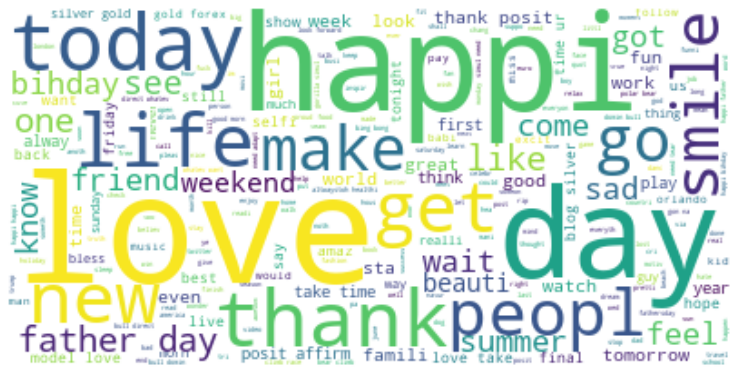

In [397]:
pos_words = []
for line in comb_df_pos: 
    line_words = line.split()
    pos_words.extend(line_words)
pos_words = ' '.join(pos_words)

stopwords_set = set(stopwords.words('english'))
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='white',
    max_words=50000,
    stopwords = stopwords_set
   ).generate(pos_words)
plt.figure(figsize=(13,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Облако слов для отзывов, содержащих токсичные комментарии

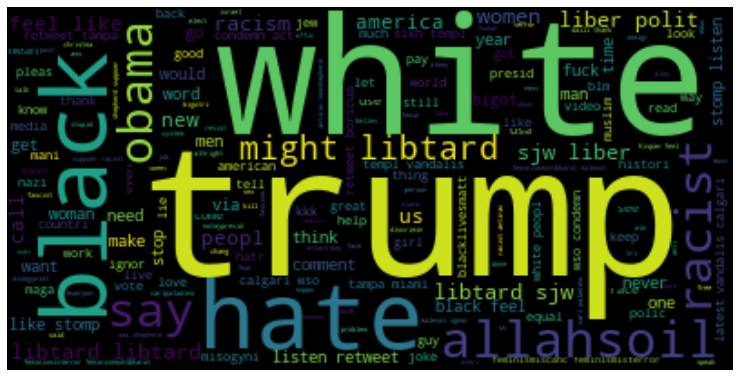

In [399]:
neg_words = []
for line in comb_df_neg: 
    line_words = line.split()
    neg_words.extend(line_words)
neg_words = ' '.join(neg_words)

stopwords_set = set(stopwords.words('english'))
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(
    background_color='black',
    max_words=50000,
    stopwords = stopwords_set
   ).generate(neg_words)
plt.figure(figsize=(13,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()